# `４章のテーマ`
- 訓練データから最適な重みを自動で設定できるようにする。


## 4.1 データから学習
- 機械学習では、データ(今回はMNST画像)から特徴量を抽出して、その特徴量のパターンを学習(規則性)する。

#### `特徴量とは`
- 入力データから本質的なデータを的確に抽出できるように設計された変換器を指す。
- 特徴量はベクトルとして記述される。
- **ニューラルネットワークはデータに含まれる重要な特徴量までも「機械」が学習する。**
- 例) 5という数字があったら、左上が角ばってて、下が逆c型になっていて、というような特徴量を機会が学習

### 4.1.2 訓練データとテストデータ
1. 機械学習では訓練(教師)データとテストデータを分ける。
2. まず、訓練データで最適なパラメーターを探してモデルを作る
3. テストデータでモデルの実力を評価する。

↑で評価するのは`汎化能力`(どんなデータにも対応できる)。逆にあるデータに過度に適応した状態を`過学習`と呼ぶ。

## 4.2 損失関数
- 分析結果を定量的に表すための関数
- 損失関数２条和誤差、交差エントロピー誤差（両方共、大きいほど悪い）

###`２乗和誤差`
$$ E = 1/2\sum_{k}(y_k - t_k)^2 $$
で表せられる関数でモデル値(yとy2)と教師データ(t)がどれくらい違うかを示す。

In [8]:
import numpy as np
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)
mean_squared_error(np.array(y), np.array(t))


0.09750000000000003

In [7]:
y2 = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
mean_squared_error(np.array(y2), np.array(t))

0.5975

tのように０と１だけの表記方法をone-hot表現という。上記の例では、y2のほうが悪いモデルということになる。

### `交差エントロピー誤差`
$$E = -\sum_{k}(t_k\log_e Y_k) $$
で表せられる関数で、自然対数(log)を使う。この自然対数によってYの部分が１より０に近ければ近いほど、悪いということになる。

In [12]:
def cross_entropy_error(y, t):
    delta = 1e-7
    return  -np.sum(t * np.log(y + delta))
cross_entropy_error(np.array(y), np.array(t))


0.510825457099338

In [13]:
cross_entropy_error(np.array(y2), np.array(t))

2.302584092994546

### `ミニバッチ学習`
$$E = - 1/N \sum_n \sum_k t_{nk} \log Y_{nk}$$
の数式では今までの例とは異なり、複数の損失関数の和を求めることができる。
そうなってくるとあまりにも大量のデータは処理しきれなくなって来る。

そこでランダムにいくつかのデータを引っ張ってきてそれを訓練用データとして採用する方法がある。それがミニバッチ学習である。
大量のデータからランダム（今回は１０個）に抜き出すためのコードは下記のものである。

In [24]:
import sys, os
sys.path.append(os.pardir)
import numpy as no
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = \
    load_mnist(normalize=True, one_hot_label=True)

print(x_train.shape) #(60000, 784)
print(t_train.shape) #(60000, 10)



train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]
np.random.choice(60000,10)

(60000, 784)
(60000, 10)


array([41481, 46703, 14504, 16027, 18706, 39980,  9187, 42754, 41898,
       35384])

In [ ]:
def cross_entropy_eroor(y,t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    batch_size = y.shape[0]
    return -np.sum(t * np.log(y + 1e-7)) /batch_size


tは教師データ。データ一つあたり（ｙの次元が１のとき）の交差エントロピー誤差を求めるときにはデータの形状を整形する。最後にバッチの枚数で正規化。


下の場合はone-hotの表示形式ではなく、単純に正解（例えば「２」とか「７」とか）をラベルとして与えられたときの実装.


In [30]:
def cross_entropy_eroor(y,t):
    if y.ndim == 1:
        t = t.resshape(1, t.size)
        y = y.reshape(1, y.size)
        
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_saze

上２つの差は最後の行のみ。
(t * np.log(y + 1e-7))→(np.log(y[np.arange(batch_size), t] + 1e-7))となっている。
後者の、(np.log(y[np.arange(batch_size), t] + 1e-7))の
**np.arange(batch_size)**
は０からbatch_size-1 までの配列を生成する。（[0, 1, 2, 3, 4, 5.....,batch_size-1])

### `ニューラルネットワークで認識精度を指標にしてはいけない`
なぜならば、認識精度は最大値を求めにくい（微分したときに０になる場所が多い：つまり変化が少ない）から。一方損失関数は、変動が多く微分を用いて今日k地を見つけやすい。※ちなみにステップ関数も同じ理由で使いにくい。


## 4.3 数値微分

`微分とはある瞬間の変化量を表したもの。`
$$\frac{df(x)}{dx} = \lim_{h \to 0} \frac{f(x+h)-f(x)}{h}$$

どんな曲線でも幅を極限まで縮めるとほぼ直線になる。その傾き(変化量)を捉えるのが微分。

np.float32(10e-50) => 0.0


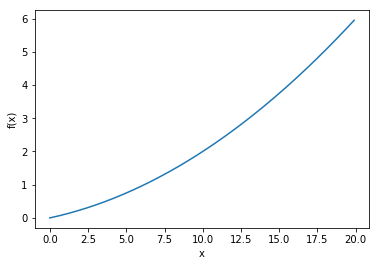

0.1999999999990898
0.2999999999986347


In [26]:
import numpy as np
import matplotlib.pylab as plt
# 微分の悪い実装例
def bad_numerical_diff(f, x): # numerical differentiation(数値微分)
    h = 10e-50
    return (f(x+h) - f(x)) / h

# 小さすぎる数字は丸め誤差が発生する(下記の結果は0になる)
print(f"np.float32(10e-50) => {np.float32(10e-50)}")

def better_numerical_deff(f, x):
    h = 1e-4 # 0.0001
    return (f(x+h) - f(x-h)) / (2*h)

def func1(x):
    return 0.01*x**2 + 0.1*x

x = np.arange(0.0, 20.0, 0.1) # 0から20まで0.1刻み
y = func1(x)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.plot(x, y)
plt.show()

# 実際の微分の値は、0.2, 0.3だが誤差は非常に小さい
print(better_numerical_deff(func1, 5)) # => 0.1999999999990898
print(better_numerical_deff(func1, 10)) # => 0.2999999999986347



### 偏微分
偏微分とは複数の変数がある式に対する微分

#変数が二つある式の微分
$$f(x_0, x_1) = x_0^2 + x_1^2$$

In [38]:
# f(x0, x1) = x0**2 + x1**2
def func2(x):
    return np.sum(x**2)

def numerical_deff(f, x):
    h = 1e-4 # 0.0001
    return (f(x+h) - f(x-h)) / (2*h)

# 問1. x0 = 3, x1 = 4の時のx0に対する偏微分を求めよ。
def func_for_q1(x0):
    return x0*x0 + 4.0**2.0

print(numerical_deff(func_for_q1, 3.0))

# 問2. x0 = 3, x1 = 4の時のx1に対する偏微分を求めよ。
def func_for_q2(x1):
    return 3.0**2.0 + x1*x1

print(numerical_deff(func_for_q2, 4.0))

6.00000000000378
7.999999999999119
